In [1]:
import Pkg;Pkg.activate(@__DIR__);Pkg.instantiate();

  Activating project at `~/Documents/eth_projects/freertos_sim/test/julia_cf2`
Precompiling project...
  ✓ julia_cf2
  1 dependency successfully precompiled in 3 seconds. 48 already precompiled.


In [1]:
using DSP
using GLMakie
using PyCall
using CSV
using DataFrames
using Accessors

using Revise
import julia_cf2

## Load data

In [2]:
df = CSV.read("./data/gyro_unfiltered.csv", DataFrame);
# print(df)

gyro_unfiltered_x = df.gyro_unfiltered_x;

## design butterworth filter 

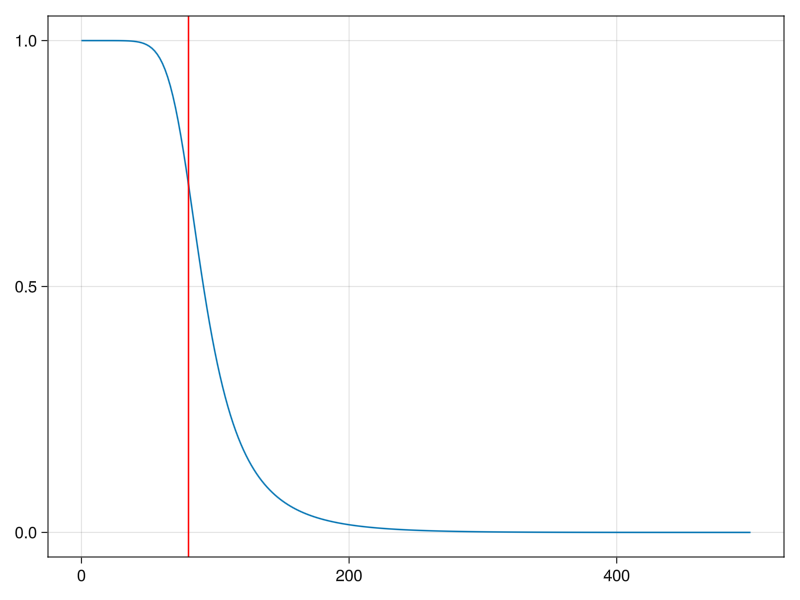

GLMakie.Screen(...)

In [3]:
f_s = 1000 # sampling time [hz]
f_c = 80 # cutoff frequency [hz]
m = 4 # filter order

responsetype = Lowpass(f_c; fs=f_s)
designmethod = Butterworth(m)

butterworth_filter = digitalfilter(responsetype, designmethod)
H, w_normalized = freqresp(butterworth_filter)

w = w_normalized * f_s
mag = abs.(H)
mag_dB = julia_cf2.normal_to_dB(mag)
w_hz = julia_cf2.rad_per_sample_to_hz(w)

f = Figure()
ax1 = Axis(f[1, 1])
lines!(ax1, w_hz, mag)
vlines!(ax1, [f_c], color=:red)

display(f)

## Apply filter

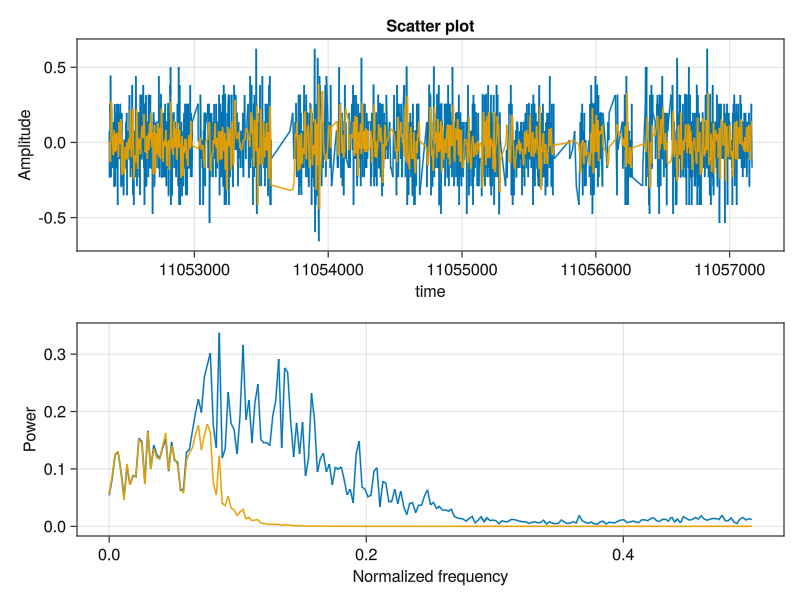

GLMakie.Screen(...)

In [4]:
gyro_filtered_x = filt(butterworth_filter, gyro_unfiltered_x)

f = Figure()

ax1 = Axis(f[1, 1], title = "Scatter plot", xlabel = "time", ylabel = "Amplitude")
ax2 = Axis(f[2, 1], xlabel = "Normalized frequency", ylabel = "Power")

lines!(ax1, df.timestamp, gyro_unfiltered_x)
lines!(ax1, df.timestamp, gyro_filtered_x)

# plot periodogram
gyro_unfiltered_x_pg = welch_pgram(gyro_unfiltered_x);
gyro_filtered_x_pg = welch_pgram(gyro_filtered_x);

# f = Figure()


lines!(ax2, gyro_unfiltered_x_pg.freq, gyro_unfiltered_x_pg.power)
lines!(ax2, gyro_filtered_x_pg.freq, gyro_filtered_x_pg.power)
display(f)


# Design Chebushev filter

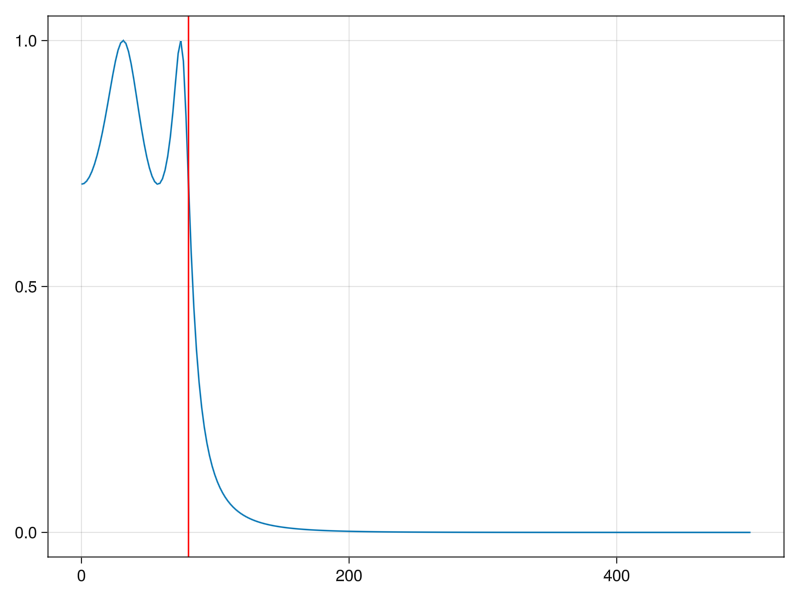

GLMakie.Screen(...)

In [5]:
ripple = 3 # max passband ripple in dB
f_s = 1000 # sampling time [hz]
f_c = 80 # cutoff frequency [hz]
m = 4 # filter order

responsetype = Lowpass(f_c; fs=f_s)
designmethod = Chebyshev1(m,ripple )

chebyshev_filter = digitalfilter(responsetype, designmethod)
H, w_normalized = freqresp(chebyshev_filter)

w = w_normalized * f_s
mag = abs.(H)
mag_dB = julia_cf2.normal_to_dB(mag)
w_hz = julia_cf2.rad_per_sample_to_hz(w)

f = Figure()
ax1 = Axis(f[1, 1])
lines!(ax1, w_hz, mag)
vlines!(ax1, [f_c], color=:red)

display(f)

## Apply filter

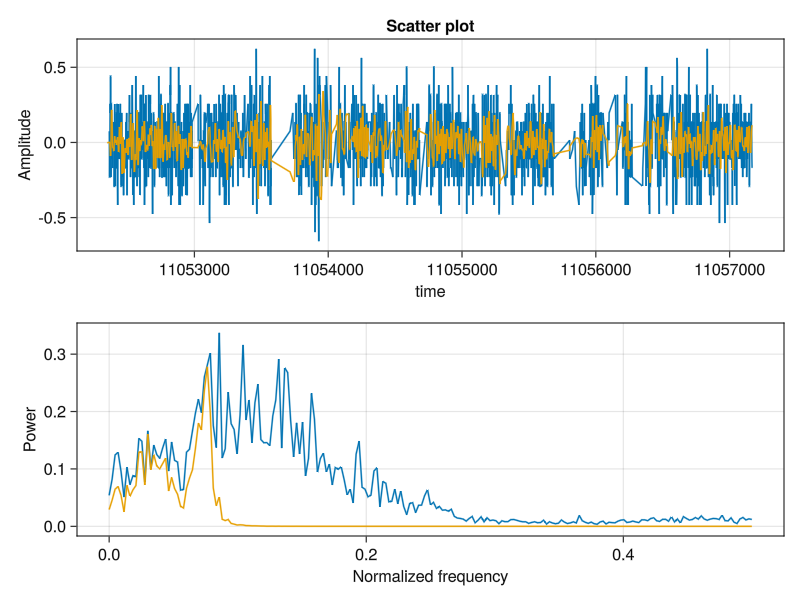

GLMakie.Screen(...)

In [6]:
gyro_filtered_x = filt(chebyshev_filter, gyro_unfiltered_x)

f = Figure()

ax1 = Axis(f[1, 1], title = "Scatter plot", xlabel = "time", ylabel = "Amplitude")
ax2 = Axis(f[2, 1], xlabel = "Normalized frequency", ylabel = "Power")

lines!(ax1, df.timestamp, gyro_unfiltered_x)
lines!(ax1, df.timestamp, gyro_filtered_x)

# plot periodogram
gyro_unfiltered_x_pg = welch_pgram(gyro_unfiltered_x);
gyro_filtered_x_pg = welch_pgram(gyro_filtered_x);

# f = Figure()


lines!(ax2, gyro_unfiltered_x_pg.freq, gyro_unfiltered_x_pg.power)
lines!(ax2, gyro_filtered_x_pg.freq, gyro_filtered_x_pg.power)
display(f)


## CMSIS DSP 

In [16]:
# get second order sections 
sos = convert(SecondOrderSections, digitalfilter(responsetype, designmethod));

n_sections = size(sos.biquads,1)
println("No of sections: ", n_sections)

sos_cmsis = sos

# flip the sign of a coefficients 
sos_cmsis = @set sos_cmsis.biquads[1].a1 = -sos.biquads[1].a1;
sos_cmsis = @set sos_cmsis.biquads[1].a2 = -sos.biquads[1].a2;
sos_cmsis = @set sos_cmsis.biquads[2].a1 = -sos.biquads[2].a1;
sos_cmsis = @set sos_cmsis.biquads[2].a2 = -sos.biquads[2].a2;

# arrange coefficients in format required by CMSIS-DSP
coeff = [
        sos_cmsis.biquads[1].b0 * sos.g
        sos_cmsis.biquads[1].b1 * sos.g
        sos_cmsis.biquads[1].b2 * sos.g
        sos_cmsis.biquads[1].a1 
        sos_cmsis.biquads[1].a2 
        sos_cmsis.biquads[2].b0 
        sos_cmsis.biquads[2].b1
        sos_cmsis.biquads[2].b2 
        sos_cmsis.biquads[2].a1 
        sos_cmsis.biquads[2].a2 
        ]

No of sections: 2


10-element Vector{Float64}:
  0.00044127037475457184
  0.0008825407495091437
  0.00044127037475457184
  1.7649945303458097
 -0.8111980508344275
  1.0
  2.0
  1.0
  1.704866789708997
 -0.9207156133757171

In [10]:
cmsisdsp = pyimport("cmsisdsp")

# convert input data to float32
gyro_unfiltered_x_f32 = convert(Vector{Float32}, gyro_unfiltered_x)

# instance of fixed-point Biquad cascade filter
biquadf32 = cmsisdsp.arm_biquad_casd_df1_inst_f32()

# state array to initialize instance
numStages=n_sections
state2::Vector{Float32} = zeros(numStages*4)

# convert filter coeff to f32 format
coeff_f32_ = convert(Vector{Float32}, coeff )

# error checking for coefficient matrix shape
@assert size(coeff_f32_,1) == 5*numStages

# error checking for coefficient matrix shape
@assert size(state2,1) == 4*numStages

# initialize filter
cmsisdsp.arm_biquad_cascade_df1_init_f32(biquadf32,numStages,coeff_f32_,state2)

#  apply filter 
gyro_filtered_cmsis_f32_x = cmsisdsp.arm_biquad_cascade_df1_f32(biquadf32, gyro_unfiltered_x_f32);

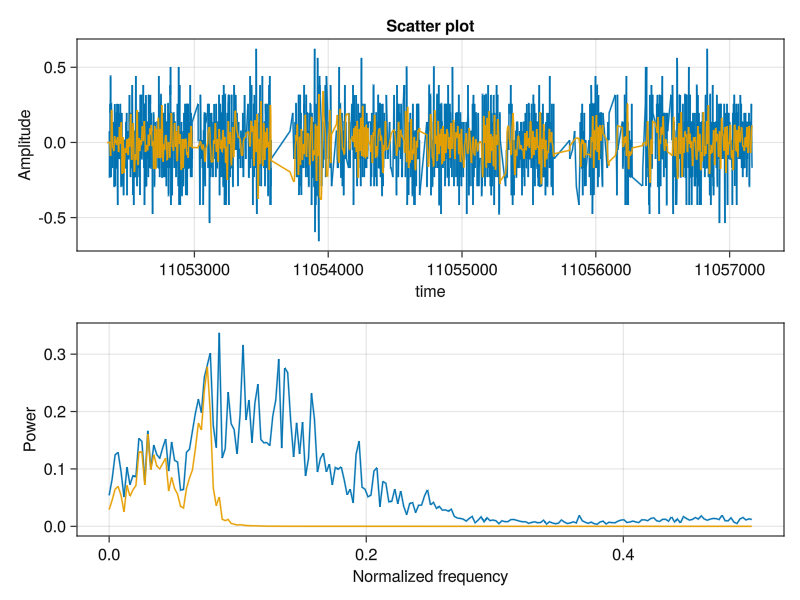

GLMakie.Screen(...)

In [17]:
f = Figure()

ax1 = Axis(f[1, 1], title = "Scatter plot", xlabel = "time", ylabel = "Amplitude")
ax2 = Axis(f[2, 1], xlabel = "Normalized frequency", ylabel = "Power")

lines!(ax1, df.timestamp, gyro_unfiltered_x)
lines!(ax1, df.timestamp, gyro_filtered_cmsis_f32_x)

# plot periodogram
gyro_unfiltered_x_pg = welch_pgram(gyro_unfiltered_x);
gyro_filtered_x_pg = welch_pgram(gyro_filtered_cmsis_f32_x);

lines!(ax2, gyro_unfiltered_x_pg.freq, gyro_unfiltered_x_pg.power)
lines!(ax2, gyro_filtered_x_pg.freq, gyro_filtered_x_pg.power)
display(f)
